# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам

# <center>Финальный проект

## Цели и задачи проекта:
Целью проекта является идентификация пользователя по посещённым им веб-страницам. В рамках поставленной цели решается задача определения пользователя с именем Алиса среди других 400 пользователей.

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import seaborn as sns
from glob import glob
from collections import OrderedDict
from scipy import stats
from scipy.sparse import csr_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from statsmodels.stats.proportion import proportion_confint
%matplotlib inline
from matplotlib import pyplot as plt

## Подготовка обучающей выборки

Реализуем функцию *prepare_train_set* с аргументами на вход
- *path_to_csv_files* - путь к каталогу с csv-файлами;
- *session_length* – длина сессии,

которая возвращает 2 объекта:
- DataFrame, в котором строки соответствуют уникальным сессиям из *session_length* сайтов, а (*session_length* +1) столбец – индексы этих *session_length* сайтов и целевой столбец (1 для сессий Алисы и 0 для сессий остальных пользователей);
- частотный словарь сайтов вида *{'site_string': [site_id, site_freq]}*.

In [2]:
def prepare_train_set(path_to_csv_files, session_length = 10):
    files = sorted(glob(path_to_csv_files+'/*.csv'))
    n_files = len(files)
    cols = ['site' + str(k) for k in range(1,session_length+1)]
    data = pd.DataFrame(columns = cols + ['target'])
    sites_freq = {}
    for k in range(n_files):
        file_sites = pd.read_csv(files[k])['site']
        sites_1 = file_sites.values
        df = pd.DataFrame(np.append(sites_1,np.array([0]*(-len(sites_1)%session_length))).reshape((-1,session_length)), 
                           columns = cols)
        df['target'] = 1 if k == 0 else 0
        data = data.append(df, ignore_index = True)
        
        freq = file_sites.value_counts()
        for elem in sites_1:
            sites_freq[elem] = sites_freq[elem] + 1 if elem in sites_freq else 1
    sites = OrderedDict(sorted(sites_freq.items(), key = lambda x: x[1], reverse = True))
    sites = {key: (id+1, sites[key]) for id,key in enumerate(sites.keys())}
    sites_id = {key: id+1 for id,key in enumerate(sites.keys())}
    sites_id[0] = 0
    for k in range(1, session_length + 1):
        data['site'+str(k)] = data['site'+str(k)].map(sites_id)
    
    return data, sites

In [3]:
# Путь к файлам
PATH_TO_FILES = 'capstone_user_identification/train'

In [4]:
train_data, site_freq = prepare_train_set(PATH_TO_FILES, session_length = 10)

In [5]:
train_data.head()

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0     33     33     33      1      1    261      1    261     19     261   
1      4    261     16    261    261      4    261      4    261     261   
2      4    261    261      4     16    261      4    261      4      33   
3     12     12    103     12     16    123     76    103     76     123   
4    186    103    123    187    188    181    173    184    168      76   

  target  
0      1  
1      1  
2      1  
3      1  
4      1

Полученные признаки *site1*, ..., *site10* смысла не имеют как признаки в задаче классификации. Воспользуемся идеей мешка слов из анализа текстов. Создадим новые матрицы, в которых строкам будут соответствовать сессии из 10 сайтов, а столбцам – индексы сайтов. На пересечении строки $i$ и столбца $j$ будет стоять число $n_{ij}$ – cколько раз сайт $j$ встретился в сессии номер $i$. Делать это будем с помощью разреженных матриц Scipy.

In [6]:
def to_dense_format(matrix):
    # Переводит матрицу с неотрицательными элементами в разреженный фаормат
    indptr = [0]
    indices = []
    data = []
    for row in matrix:
        for elem in row:
            if elem == 0:
                continue
            indices.append(elem-1)
            data.append(1)
        indptr.append(len(indices))

    return csr_matrix((data, indices, indptr), dtype=int)

In [7]:
X_data, y_data = train_data.iloc[:,:-1], train_data.iloc[:,-1]
X, y = X_data.values, y_data.values
X_sparse = to_dense_format(X)

## Первичный анализ данных, проверка гипотез

**Распределение целевого класса:**

In [8]:
y_data.value_counts()

0    176362
1      2277
Name: target, dtype: int64

Дисбаланс классов очень сильный, и смотреть на долю верных ответов непоказательно.

**Посчитаем распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов.**

In [9]:
num_unique_sites = [np.unique(X[i,:]).shape[0] for i in range(X.shape[0])]

In [10]:
pd.Series(num_unique_sites).value_counts()

7     28719
6     25913
8     25757
5     21759
9     17891
4     15251
3     13670
2     12429
1      8815
10     8435
dtype: int64

In [11]:
pd.Series(num_unique_sites).hist()

**Проверяем с помощью критерия Шапиро-Уилка, что число уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов распределено нормально.**

In [12]:
print('Test statistics: %f, p-value: %f' % stats.shapiro(num_unique_sites))

Test statistics: 0.954958, p-value: 0.000000


C:\Program Files\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


**Проверяем с помощью биномиального критерия для доли, что доля случаев, когда пользователь повторно посетил какой-то сайт (то есть число уникальных сайтов в сессии < 10) велика: больше 95%.**

In [13]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')
pi_val = stats.binom_test(sum(has_two_similar), len(has_two_similar), 0.95, alternative = 'greater')
print('p-value:', pi_val)

p-value: 2.721444588611065e-08


**Строим 95% доверительный интервал Уилсона для доли случаев, когда пользователь повторно посетил какой-то сайт.**

In [14]:
wilson_interval = proportion_confint(sum(has_two_similar), len(has_two_similar), method = 'wilson')
print('Confidence interval: [%.3f, %.3f]' % wilson_interval)

Confidence interval: [0.952, 0.954]


## Визуальный анализ данных

Реализуем функцию *prepare_train_set_2* с аргументами на вход
- *path_to_csv_files* - путь к каталогу с csv-файлами;
- *site_freq* – частотный словарь, полученный ранее;
- *feature_names* – названия признаков;
- *session_length* – длина сессии (параметр),

которая создаёт новые признаки
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах);
- `#unique_sites` – число уникальных сайтов в сессии;
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти);
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

и возвращает новый DataFrame как функция *prepare_train_set*, но только на 4 признака больше.

In [15]:
def prepare_train_set_2(path_to_csv_files, site_freq, feature_names, session_length = 10):
    sites_ids = {key: id+1 for id,key in enumerate(site_freq.keys())}
    files = sorted(glob(path_to_csv_files+'/*.csv'))
    n_files = len(files)
    data_sites = pd.DataFrame(columns = feature_names)
    for k in range(n_files):
        user_data = pd.read_csv(files[k])
        sites_1 = user_data['site'].map(sites_ids).values
        n_sites = len(sites_1)
        n_sessions = (n_sites-1)//session_length + 1
        add_length = n_sessions*session_length - n_sites
        sites_2 = np.append(sites_1, np.zeros((1, add_length), dtype = int))
        sites_array = np.array([sites_2[i+j] for i in range(0,n_sessions*session_length,session_length) 
                                for j in range(session_length)]).reshape((n_sessions,session_length))
        times = pd.to_datetime(user_data['timestamp'])
        df = pd.DataFrame(np.append(sites_1,np.array([0]*(-len(sites_1)%session_length))).reshape((-1,session_length)), 
                           columns = feature_names[:session_length])
        
        session_timespan = np.zeros(n_sessions, dtype = int)
        for i in range(n_sessions-1):
            start = session_length*i
            finish = start + session_length
            session_timespan[i] = int((max(times[start:finish])-min(times[start:finish])).total_seconds())
        start = session_length*(n_sessions-1)
        session_timespan[n_sessions-1] = int((max(times[start:])-min(times[start:])).total_seconds())
        df['session_timespan'] = session_timespan
        df['#unique_sites'] = np.array([len(np.unique(sites_2[i:i+session_length])) 
                                        for i in range(0,n_sessions*session_length,session_length)])
        df['start_hour'] = np.array([min(times[i:i+session_length]).hour 
                                     for i in range(0,n_sessions*session_length,session_length)])
        df['day_of_week'] = np.array([min(times[i:i+session_length]).weekday() 
                                      for i in range(0,n_sessions*session_length,session_length)])
        df['target'] = 1 if k == 0 else 0
        data_sites = data_sites.append(df, ignore_index = True)
    return data_sites

In [16]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target']
train_data_2 = prepare_train_set_2(PATH_TO_FILES, site_freq, feature_names = feature_names, session_length = 10)

In [17]:
train_data_2.head()

site1 site2 site3 site4 site5 site6 site7 site8 site9 site10  \
0    33    33    33     1     1   261     1   261    19    261   
1     4   261    16   261   261     4   261     4   261    261   
2     4   261   261     4    16   261     4   261     4     33   
3    12    12   103    12    16   123    76   103    76    123   
4   186   103   123   187   188   181   173   184   168     76   

  session_timespan #unique_sites start_hour day_of_week target  
0              437             4         16           1      1  
1               26             3         16           1      1  
2               53             4         16           1      1  
3                3             5         16           1      1  
4                0            10         16           1      1

**Строим гистограмму распределения числа уникальных сайтов в сессии для Алисы.**

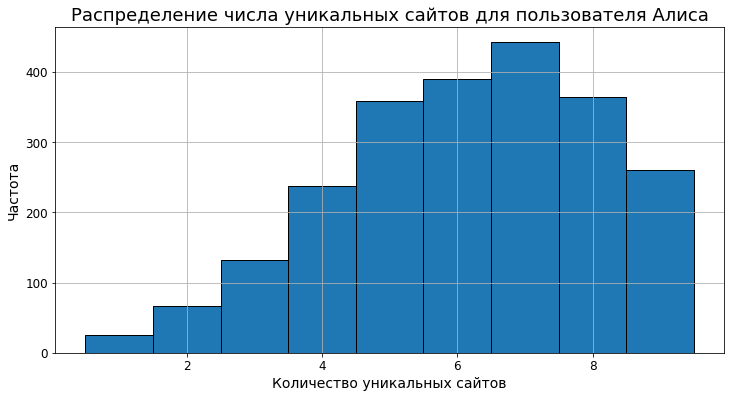

In [18]:
plt.figure(figsize = (12,6))
data = [elem for elem in train_data_2[train_data_2['target']==1]['#unique_sites']]
plt.hist(data, bins = list(range(min(data),max(data)+1)), edgecolor='black', align = 'left')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Количество уникальных сайтов', fontsize = 14)
plt.ylabel('Частота', fontsize = 14)
plt.title('Распределение числа уникальных сайтов для пользователя Алиса', fontsize = 18)
plt.grid(True)
plt.show()

**Строим гистограмму распределения часа начала сессии для Алисы.**

In [19]:
plt.figure(figsize = (12,6))
data = [elem for elem in train_data_2[train_data_2['target']==1]['start_hour']]
n, bins, patches = plt.hist(data, bins = list(range(min(data),max(data)+1)), color = 'darkgreen', 
                            edgecolor='black', align = 'left')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Час начала сессии', fontsize = 14)
plt.ylabel('Частота', fontsize = 14)
plt.title('Распределение часа начала сессии для пользователя Алиса', fontsize = 18)
plt.grid(True)
plt.show()

**Строим гистограмму распределения дня недели, в который началась сессия, для Алисы.**

In [20]:
plt.figure(figsize = (12,6))
data = [elem for elem in train_data_2[train_data_2['target']==1]['day_of_week']]
n, bins, patches = plt.hist(data, bins = list(range(8)), color = 'sienna', edgecolor='black', align = 'left')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('День недели', fontsize = 14)
plt.ylabel('Частота', fontsize = 14)
plt.title('Распределение дня недели начала сессии для пользователя Алиса', fontsize = 18)
plt.grid(True)
plt.show()

### Вывод:
Алиса, в основном, заходит в понедельник, вторник, четверг и пятницу в интервалы времени 12-13 часов и 16-17 часов. При этом большая часть посещённых сайтов может быть как уникальными, так и повторными.  

## Построение моделей

Реализуем функцию *prepare_train_set_with_fe* с аргументами на вход
- *path_to_csv_files* - путь к каталогу с csv-файлами;
- *site_freq* – частотный словарь, полученный ранее;
- *feature_names* – названия признаков;
- *session_length* – длина сессии (параметр),

и функцию *prepare_test_set_with_fe* с аргументами на вход
- *path_to_file* - путь к файлу;
- *site_freq* – частотный словарь, полученный ранее;
- *feature_names* – названия признаков;
- *session_length* – длина сессии (параметр),

которые создают новые бинарные признаки
- `start_hour_12-13` – начало сессии приходится на 12-13 часов;
- `start_hour_16-17` – начало сессии приходится на 16-17 часов;
- `day_of_week_monday` – начало сессии приходится на понедельник;
- `day_of_week_tuesday` – начало сессии приходится на вторник;
- `day_of_week_thursday` – начало сессии приходится на четверг;
- `day_of_week_friday` – начало сессии приходится на пятницу

и возвращают новые DataFrame как функция *prepare_train_set*, но только на 6 признаков больше и отсортированные по времени начала сессий.

In [21]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq, feature_names, session_length = 10):
    sites_ids = {key: id+1 for id,key in enumerate(site_freq.keys())}
    files = sorted(glob(path_to_csv_files+'/*.csv'))
    n_files = len(files)
    data_sites = pd.DataFrame(columns = feature_names + ['session_start'])
    for k in range(n_files):
        user_data = pd.read_csv(files[k])
        sites_1 = user_data['site'].map(sites_ids).values
        n_sites = len(sites_1)
        n_sessions = (n_sites-1)//session_length + 1
        add_length = n_sessions*session_length - n_sites
        sites_2 = np.append(sites_1, np.zeros((1, add_length), dtype = int))
        sites_array = np.array([sites_2[i+j] for i in range(0,n_sessions*session_length,session_length) 
                                for j in range(session_length)]).reshape((n_sessions,session_length))
        times = pd.to_datetime(user_data['timestamp'])
        df = pd.DataFrame(np.append(sites_1,np.array([0]*(-len(sites_1)%session_length))).reshape((-1,session_length)), 
                           columns = feature_names[:session_length])
        session_start = []
        for i in range(n_sessions-1):
            start = session_length*i
            session_start.append(times[start])
        start = session_length*(n_sessions-1)
        session_start.append(times[start])
        df['session_start'] = session_start
        df['start_hour_12-13'] = [(time.hour in [12,13]) + 0 for time in session_start]
        df['start_hour_16-17'] = [(time.hour in [16,17]) + 0 for time in session_start]
        df['day_of_week_monday'] = [(time.weekday() == 0) + 0 for time in session_start]
        df['day_of_week_tuesday'] = [(time.weekday() == 1) + 0 for time in session_start]
        df['day_of_week_thursday'] = [(time.weekday() == 3) + 0 for time in session_start]
        df['day_of_week_friday'] = [(time.weekday() == 4) + 0 for time in session_start]
        df['target'] = 1 if k == 0 else 0
        data_sites = data_sites.append(df, ignore_index = True)
    
    data_sites = data_sites.sort_values(['session_start']).reset_index(drop=True)
    data_sites = data_sites[feature_names]
    return data_sites

In [22]:
feature_names = ['site' + str(i) for i in range(1,11)] + ['start_hour_12-13', 'start_hour_16-17'] + \
                ['day_of_week_monday', 'day_of_week_tuesday', 'day_of_week_thursday', 'day_of_week_friday', 'target']
train_data_with_fe = prepare_train_set_with_fe(PATH_TO_FILES, site_freq, feature_names = feature_names, session_length = 10)

**Разбиваем обучающую выборку на 2 части в пропорции 7/3.**

In [23]:
X_sparse_2, y_2 = to_dense_format(train_data_with_fe.iloc[:,:-1].values), train_data_with_fe.iloc[:,-1].values
y_2 = np.array([k for k in y_2])

In [24]:
train_share = int(0.7*X_sparse_2.shape[0])
X_train, y_train = X_sparse_2[:train_share,:], y_2[:train_share]
X_valid, y_valid = X_sparse_2[train_share:,:], y_2[train_share:]

**Задаём тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [25]:
skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 17)

### SGD Classifier

**Создаём объект `SGDClassifier` с логистической функцией потерь и параметром *random_state*=17.**

In [26]:
sgd_logit = SGDClassifier(loss = 'log', n_jobs = -1, random_state = 17, class_weight = 'balanced')

**Используем `GridSearchCV` для подбора параметра регуляризации `alpha`, при котором прогноз будет наилучшим.**

In [27]:
%%time
sgd_logit_grid = GridSearchCV(estimator = sgd_logit, param_grid = {'alpha': np.logspace(-6,-1,6)}, 
                   n_jobs = -1, scoring = 'roc_auc', cv = skf)
sgd_logit_grid.fit(X_train, y_train)
alpha_optimal = sgd_logit_grid.best_params_['alpha']
print('Optimal value of alpha:', alpha_optimal)

Optimal value of alpha: 0.001
Wall time: 6.34 s


**Делаем прогноз, что это сессия Элис, на отложенной выборке `(X_valid, y_valid)` и считаем ROC AUC.**

In [28]:
sgd_logit_opt = SGDClassifier(loss = 'log', alpha = alpha_optimal, n_jobs = -1, random_state = 17)
sgd_logit_opt.fit(X_train, y_train)
print('ROC AUC:', np.round(roc_auc_score(y_valid, sgd_logit_opt.predict_proba(X_valid)[:,1]), 3))

ROC AUC: 0.671


### Logistic Regression

**Подбираем с помощью `LogisticRegressionCV` параметр регуляризации `C` для `LogisticRegression`.**

In [29]:
%%time
C_values1 = np.logspace(-4, 1, 11)
logit_grid_searcher1 = LogisticRegressionCV(Cs = C_values1, cv = skf, scoring = 'roc_auc', class_weight='balanced', 
                                            n_jobs = -1, random_state = 17)
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 31.2 s


Оптимальное значение C: 0.1


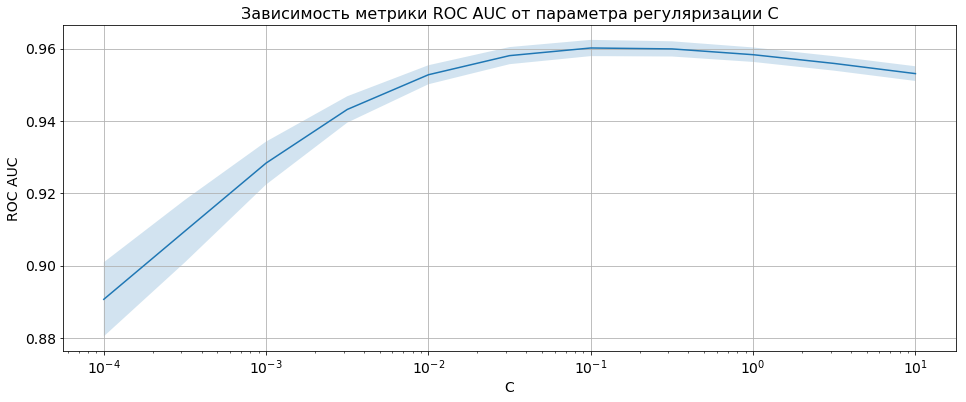

In [30]:
print('Оптимальное значение C:', np.round(logit_grid_searcher1.C_[0],5))

plt.figure(figsize=(16,6))
plt.title('Зависимость метрики ROC AUC от параметра регуляризации С', size = 16)
mean, std = logit_grid_searcher1.scores_[1].mean(axis=0), logit_grid_searcher1.scores_[1].std(axis = 0)
plt.plot(C_values1, mean, '-')
plt.xscale('log')
plt.fill_between(C_values1, mean - std, mean + std, edgecolor = 'none', alpha = 0.2)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.xlabel('C', size = 14)
plt.ylabel('ROC AUC', size = 14)
plt.grid(True)
plt.show()

**Уточняем оптимальное значение `C`.**

In [31]:
%%time
index_opt = list(C_values1).index(logit_grid_searcher1.C_[0])
c_min = C_values1[index_opt-1] if index_opt > 0 else C_values1[0]**2/C_values1[1]
c_max = C_values1[index_opt+1] if index_opt < len(C_values1) else C_values1[-1]**2/C_values1[-2]
C_values2 = np.logspace(np.log10(c_min), np.log10(c_max), 9)
logit_grid_searcher2 = LogisticRegressionCV(Cs = C_values2, cv = skf, scoring = 'roc_auc', class_weight='balanced', 
                                            n_jobs = -1, random_state = 17)
logit_grid_searcher2.fit(X_train, y_train)

index_opt = list(C_values2).index(logit_grid_searcher2.C_[0])
c_min = C_values2[index_opt-1] if index_opt > 0 else C_values2[0]**2/C_values2[1]
c_max = C_values2[index_opt+1] if index_opt < len(C_values2) else C_values2[-1]**2/C_values2[-2]
C_values3 = np.logspace(np.log10(c_min), np.log10(c_max), 9)
logit_grid_searcher3 = LogisticRegressionCV(Cs = C_values3, cv = skf, scoring='roc_auc', class_weight='balanced', 
                                            n_jobs = -1, random_state = 17)
logit_grid_searcher3.fit(X_train, y_train)
logit_C_opt = logit_grid_searcher3.C_[0]

Wall time: 1min 9s


Уточнённое оптимальное значение C: 0.15399


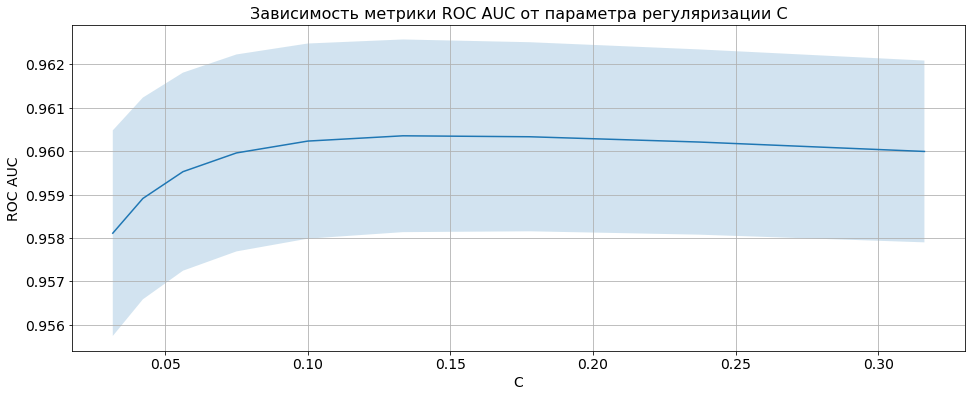

In [32]:
print('Уточнённое оптимальное значение C:', np.round(logit_C_opt,5))

plt.figure(figsize=(16,6))
plt.title('Зависимость метрики ROC AUC от параметра регуляризации С', size = 16)
mean, std = logit_grid_searcher2.scores_[1].mean(axis=0), logit_grid_searcher2.scores_[1].std(axis = 0)
plt.plot(C_values2, mean, '-')
plt.fill_between(C_values2, mean - std, mean + std, edgecolor = 'none', alpha = 0.2)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.xlabel('C', size = 14)
plt.ylabel('ROC AUC', size = 14)
plt.grid(True)
plt.show()

**Делаем прогноз, что это сессия Алисы, на отложенной выборке `(X_valid, y_valid)` и считаем ROC AUC.**

In [33]:
print('ROC AUC:', np.round(roc_auc_score(y_valid, logit_grid_searcher3.predict_proba(X_valid)[:,1]), 3))

ROC AUC: 0.904


## Выводы

Построены две модели идентификации пользователя среди множества других. Первая модель использует стохастический градиентный спуск и позволяет довольно быстро и с хорошей точностью определять конкретного пользователя. Вторая модель основана на
логистической регрессии и решает задачу с более высокой точностью, однако требует больше времени.

Результат можно попробовать улучшить, рассмотрев больше признаков. Также можно попробовать использовать библиотеку Vowpal Wabbit.